<div align="center">

<img src="https://www.isel.pt/sites/default/files/001_imagens_isel/Logotipos/ISEL%202025/01_ISEL-Logotipo-RGB_Horizontal-Principal-900_0.png" 
     alt="ISEL" width="500"/>

<h2>Trabalho Laboratorial 2 — Classificação de Críticas de Cinema do IMDb</h2>

<br/>

**Curso:** Engenharia Informática e Multimédia  
**Unidade Curricular:** Aprendizagem Automática  
**Docente:** Gonçalo Xufre  
**Turma:** 52D  

<br/>

**Alunos:**

<table style="width: 60%; text-align: center;">
    <tr>
      <th>Número</th>
      <th>Aluno</th>
      <th>E-mail</th>
    </tr>
    <tr>
      <td>48626</td>
      <td>Diogo Santos</td>
      <td>a48626@alunos.isel.pt</td>
    </tr>
    <tr>
      <td>50299</td>
      <td>Tatiana Damaya</td>
      <td>a50299@alunos.isel.pt</td>
    </tr>
</table>

<br/>

**Ano Letivo:** 2025/2026  

<h4>23 de Dezembro de 2025 — Lisboa</h4>

</div>

---


## Índice

- [1. Introdução](#introducao)

- [2. Dados](#dados)
  - [Imports](#imports)
  - [Ficheiro `imdbFull.p`](#imdbFull)

- [3. Desenvolvimento](#desenvolvimento)
  - [3.1 Construção do vocabulário](#vocabulario)
  - [3.2 Classificação e regressão](#regressao)
  - [3.3 Metodologias de teste e métricas de desempenho](#desempenho)
  - [3.4 Clustering](#clustering)

- [4. Conclusão](#conclusao)

</div>

---

## Introdução <a id="introducao"></a>

O presente trabalho insere-se no âmbito da unidade curricular de **Aprendizagem
Automática** e tem como objetivo a aplicação de diferentes técnicas de *Machine
Learning* ao problema da **classificação de críticas de cinema** da base de dados
IMDb.

O conjunto de dados utilizado é composto por textos de críticas de cinema,
associados a uma pontuação numa escala de 1 a 10. As críticas consideradas neutras
(pontuações 5 e 6) foram excluídas, resultando num problema de aprendizagem com
classes bem definidas.

O trabalho está dividido em três partes principais. Numa primeira fase, é feita a
construção de um vocabulário a partir dos textos, recorrendo à representação
**TF-IDF**, após um processo de limpeza e pré-processamento. De seguida, são
exploradas duas abordagens supervisionadas: **classificação** e **regressão**, usando
o mesmo vocabulário, de forma a permitir uma comparação justa entre os modelos.

Por fim, é realizada uma tarefa de **clustering**, onde se procura agrupar as
críticas de forma não supervisionada, analisando os padrões semânticos existentes
no texto sem recorrer às pontuações atribuídas.

Ao longo do trabalho são utilizadas metodologias de teste adequadas e diferentes
métricas de desempenho, permitindo avaliar e comparar os modelos de forma
fundamentada.


---

## Dados <a id="dados"></a>

### Imports <a id="imports"></a>

In [37]:
# Instalação de dependências necessárias
%pip install -q nltk

# Utilitários base
import pickle
import numpy as np
import pandas as pd
import re

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Classificação
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Regressão
from sklearn.linear_model import Ridge

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)

# Estilo dos gráficos
sns.set(style="whitegrid")


Note: you may need to restart the kernel to use updated packages.


### Ficheiro `imdbFull.p` <a id="imdbFull"></a>

O ficheiro `imdbFull.p` corresponde a uma base de dados de críticas de cinema recolhidas
da Internet Movie Database (IMDb), originalmente disponibilizada por Andrew Maas.

Os dados encontram-se armazenados sob a forma de um dicionário, que contém as seguintes
chaves principais:

- **`data`**: lista de textos correspondentes às críticas de cinema;
- **`target`**: vetor com as pontuações atribuídas a cada crítica, numa escala de 1 a 10,
  excluindo as classes neutras (5 e 6);
- **`DESCR`**: descrição textual da base de dados.


In [38]:
with open('imdbFull.p', 'rb') as f:
	dados = pickle.load(f)

print("Chaves do dicionário:", dados.keys())
print("Número de textos de críticas de cinema:", len(dados.data))
print("Número de pontuações da crítica:", len(dados.target))
print("Pontuações únicas:", set(dados["target"]))
print("Descrição da Base de Dados:", dados.DESCR)

Chaves do dicionário: dict_keys(['data', 'target', 'DESCR'])
Número de textos de críticas de cinema: 50000
Número de pontuações da crítica: 50000
Pontuações únicas: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(8), np.int64(9), np.int64(10)}
Descrição da Base de Dados: This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.
For more details see: http://ai.stanford.edu/~amaas/data/sentiment/


Para tornar o conjunto de dados compatível com as ferramentas do `scikit-learn`, procedeu-se à separação entre a matriz de características (X) e o vetor alvo (y).
Neste caso, X corresponde aos textos das críticas de cinema e y às respetivas pontuações associadas.

```python
X = dados["data"]
y = np.array(dados["target"])
```
De modo a avaliar corretamente o desempenho dos modelos de aprendizagem automática, o conjunto de dados foi dividido em subconjuntos de treino e teste. Optou-se por uma divisão de 80% dos dados para treino e 20% para teste.

A separação foi realizada de forma aleatória `(shuffle=True)` e utilizando o parâmetro `(stratify=y)`, garantindo que a distribuição das diferentes classes/pontuações de 1 a 10 se mantém proporcional em ambos os subconjuntos. Foi ainda definido um valor fixo para o parâmetro `(random_state=42)`, de forma a que a divisão dos dados seja sempre a mesma sempre que o código é executado.

In [39]:
# Extração da matriz de features (X) e vetor alvo (y)
X = dados["data"]
y = np.array(dados["target"])

# Separação entre dados de treino e teste
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y
)

print("Treino:", len(Xtrain), len(ytrain),
      "Teste:", len(Xtest), len(ytest))

Treino: 40000 40000 Teste: 10000 10000


</div>

---

## 3. Desenvolvimento <a id="desenvolvimento"></a>

### 3.1 Construção do vocabulário <a id="vocabulario"></a>

Antes da construção do vocabulário, foi realizado um pré-processamento dos textos
das críticas de cinema. Este passo teve como objetivo reduzir ruído e normalizar
os dados, contribuindo para um melhor desempenho dos modelos de aprendizagem
automática.

Dado que os dados provêm da web (IMDb), aplicou-se um conjunto de operações de
limpeza para remover elementos não relevantes. O pré-processamento incluiu:
- Substituição das quebras de linha HTML (`<br />`) por espaços;
- Remoção de números, pontuação e caracteres especiais;
- Manutenção apenas de letras (incluindo caracteres acentuados) e espaços;
- Aplicação de *stemming* recorrendo ao algoritmo **Snowball Stemmer**, cujo
  objetivo é reduzir as palavras à sua raiz morfológica (por exemplo,
  *acting*, *acted* → *act*). Esta abordagem permite reduzir a dimensionalidade do
  vocabulário e agrupar termos semanticamente equivalentes, facilitando a tarefa
  dos modelos de aprendizagem automática.

A separação dos dados em conjuntos de treino (80%) e teste (20%) foi realizada
antes da construção do vocabulário. Esta abordagem evita fuga de informação
(*data leakage*), garantindo que o vocabulário é construído exclusivamente com
base nos dados de treino, sem acesso a informação proveniente do conjunto de
teste.

De seguida, apresenta-se um exemplo ilustrativo de uma crítica antes e depois do
processo de limpeza.

In [40]:
# Exemplo de texto antes da limpeza
print("Texto antes da limpeza:\n", Xtrain[1])

# Inicialização do stemmer
stemmer = SnowballStemmer("english")

# Função de limpeza + stemming
# Atenção: Este passo pode demorar 1-2 minutos devido ao volume de dados
def preprocess_text(doc):
    # Remover quebras de linha HTML
    doc = doc.replace('<br />', ' ')
    
    # Manter apenas letras
    doc = re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc)
    
    # Converter para minúsculas e aplicar stemming
    words = [stemmer.stem(w) for w in doc.lower().split()]
    
    return ' '.join(words)

# Aplicar ao treino e ao teste separadamente
Xtrain_clean = [preprocess_text(doc) for doc in Xtrain]
Xtest_clean  = [preprocess_text(doc) for doc in Xtest]

# Exemplo de texto depois da limpeza + stemming
print("\nTexto depois da limpeza e stemming:\n", Xtrain_clean[1])


Texto antes da limpeza:
 I watched the pilot and noticed more than a few similarities between 3 lbs and House, M.D.. Tucci's character is brilliant but socially inept out of choice, similar to Laurie's character House, but without the acerbic wit that Laurie brings to House. Meanwhile, Tucci's 'straight guy', the emphatic doctor Seger, is not developed into a more interesting character, like the fallible 'straight guys' Cuddy and Wilson. Indira Varma's character Adrienne Holland is too similar to Jennifer Morrison's doctor Cameron to be a co-incidence.<br /><br />Someone at CBS obviously noticed the success of House, M.D. and told his staff to get him (her) a similar show, hoping that mimicry would prove successful. However, copying a show like House demands the same high level balance of wit and suspense and Tucci and company are just not up to the challenge.<br /><br />I didn't know the show was canceled until I read the comments on IMDb, but it doesn't come as a surprise to me.

Tex

Após o pré-processamento dos textos, foi utilizada a técnica TF-IDF (*Term
Frequency – Inverse Document Frequency*) através da função `TfidfVectorizer`.
Este método permite converter os textos numa representação numérica, atribuindo
maior importância a palavras mais relevantes e reduzindo o peso de termos muito
frequentes no conjunto de dados.

Com o objetivo de controlar a dimensão do vocabulário e reduzir ruído, foram
definidos os seguintes parâmetros:
- `lowercase=True`: para garantir que palavras iguais não são tratadas como termos
  diferentes apenas devido ao uso de maiúsculas ou minúsculas;
- `stop_words='english'`: para remover palavras muito comuns da língua inglesa,
  como *the*, *and* ou *is*, que não contribuem para distinguir o conteúdo das
  críticas;
- `max_features=5000`: para limitar o tamanho do vocabulário e reduzir o custo
  computacional;
- `max_df=0.9`: para eliminar termos demasiado frequentes e pouco
  discriminativos;
- `min_df=5`: para remover palavras muito raras, garantindo que apenas termos com
  ocorrência mínima em cinco críticas são considerados. Esta restrição contribui
  para evitar a chamada *maldição da dimensionalidade* e manter apenas os termos
  com maior poder discriminativo.

In [41]:
# --- Construção do vocabulário com TF-IDF ---
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=5000,
    max_df=0.9,
    min_df=5
)

# Aprender o vocabulário apenas com o treino
Xtrain_tfidf = vectorizer.fit_transform(Xtrain_clean)
# Aplicar o mesmo vocabulário ao teste
Xtest_tfidf = vectorizer.transform(Xtest_clean)

print("Dimensão da matriz TF-IDF (Treino):", Xtrain_tfidf.shape)
print("Dimensão da matriz TF-IDF (Teste):", Xtest_tfidf.shape)
print("Tamanho do vocabulário:", len(vectorizer.get_feature_names_out()))

# ---- Demonstração simples do efeito do vocabulário ----
# Texto limpo de exemplo (do conjunto de treino)
texto_limpo = Xtrain_clean[0].split()
print("\nNúmero de palavras no texto limpo:", len(texto_limpo))

# Palavras do texto que fazem parte do vocabulário final
feature_set = set(vectorizer.get_feature_names_out())
palavras_no_vocab = [w for w in texto_limpo if w in feature_set]

print("Número de palavras consideradas no vocabulário TF-IDF:", len(palavras_no_vocab))
print("\nExemplo de palavras antes do TF-IDF:")
print(texto_limpo)
print("\nExemplo de palavras consideradas no vocabulário:")
print(palavras_no_vocab)

Dimensão da matriz TF-IDF (Treino): (40000, 5000)
Dimensão da matriz TF-IDF (Teste): (10000, 5000)
Tamanho do vocabulário: 5000

Número de palavras no texto limpo: 126
Número de palavras consideradas no vocabulário TF-IDF: 53

Exemplo de palavras antes do TF-IDF:
['i', 'just', 'watch', 'this', 'an', 'earli', 'harold', 'lloyd', 'short', 'film', 'that', 'featur', 'his', 'glass', 'charact', 'on', 'kino', 'video', 's', 'dvd', 'of', 'the', 'harold', 'lloyd', 'collect', 'he', 's', 'actual', 'a', 'con', 'man', 'with', 'snub', 'pollard', 'as', 'his', 'partner', 'who', 'get', 'discov', 'by', 'bebe', 'daniel', 'who', 'herself', 'perform', 'fake', 'séanc', 'what', 'she', 'discov', 'is', 'that', 'lloyd', 'and', 'pollard', 'bilk', 'mani', 'custom', 'by', 'drop', 'fake', 'ring', 'that', 'are', 'lost', 'i', 'll', 'stop', 'there', 'and', 'just', 'say', 'this', 'was', 'quit', 'funni', 'especi', 'when', 'harold', 'and', 'snub', 'enter', 'the', 'place', 'bebe', 'work', 'and', 'encount', 'some', 'creepi',

#### Observações da Construção do vocabulário

A aplicação do TF-IDF resultou numa matriz de características com dimensão
(40 000, 5 000) para o conjunto de treino e (10 000, 5 000) para o conjunto de
teste, correspondendo a um total de 50 000 críticas representadas através de um
vocabulário final com 5 000 termos.

Analisando um exemplo de uma crítica do conjunto de treino, o texto limpo
continha inicialmente 126 palavras, das quais apenas 53 foram consideradas no
vocabulário final utilizado pelo modelo. Este resultado evidencia que o processo
de construção do vocabulário eliminou uma parte significativa dos termos do texto
original, reduzindo ruído e redundância.

Observa-se ainda que as palavras mantidas correspondem maioritariamente a termos
relevantes para o conteúdo da crítica, como *film*, *harold*, *funni*, *character*
ou *recommend*. Por outro lado, palavras genéricas e pouco informativas, como
artigos, pronomes e preposições, não são consideradas. A aplicação de *stemming*
é visível na forma reduzida de algumas palavras, contribuindo para a diminuição
da dimensionalidade do vocabulário e para uma representação mais consistente dos
textos.


### 3.2 Classificação e regressão <a id="regressao"></a>

Após a construção do vocabulário com **TF-IDF**, foram aplicados dois modelos de
classificação supervisionada: **`LinearSVC` (SVM linear)** e
**`LogisticRegression`**. Ambos os modelos utilizaram exatamente o mesmo
vocabulário e a mesma representação vetorial, garantindo uma comparação justa
entre as abordagens.

Para cada classificador foi utilizada validação cruzada através do
`GridSearchCV`, com `cv=3`, de forma a testar diferentes valores do parâmetro de
regularização `C`. Este parâmetro controla o compromisso entre a simplicidade do
modelo e a sua capacidade de se ajustar aos dados.

Foram testados os valores `C = {0.01, 0.1, 1, 10}`, de modo a cobrir diferentes
níveis de regularização:
- valores baixos de `C` (0.01 e 0.1) impõem uma regularização mais forte,
  originando modelos mais simples e menos propensos a sobreajuste;
- o valor intermédio `C = 1` corresponde a um equilíbrio entre regularização e
  capacidade de ajuste;
- valores mais elevados de `C` (10) permitem maior flexibilidade do modelo,
  podendo capturar padrões mais complexos, mas com maior risco de sobreajuste.

A avaliação final foi efetuada no conjunto de teste, recorrendo à métrica de **accuracy**, bem como ao
`classification_report`, que apresenta medidas de **precisão**, **revocação** e **f1-score** para cada classe.

Para uma análise mais detalhada dos resultados, foi ainda apresentada a
**matriz de confusão** de cada modelo, permitindo identificar padrões de erro e
avaliar quais as classes mais frequentemente confundidas.

A utilização de dois classificadores distintos permite comparar uma abordagem
baseada na maximização de margens, como o `LinearSVC`, com um modelo linear de
natureza probabilística, como a `LogisticRegression`, avaliando qual destes se
revela mais adequado à tarefa de classificação das críticas de cinema.



=== Classificação com LinearSVC ===

Melhor parâmetro C encontrado: 0.1
Melhor accuracy na validação cruzada (Treino): 0.4170

--- Avaliação no Conjunto de Teste ---
              precision    recall  f1-score   support

           1       0.52      0.83      0.64      2024
           2       0.21      0.05      0.09       917
           3       0.25      0.12      0.16       992
           4       0.32      0.26      0.29      1066
           7       0.31      0.21      0.25       961
           8       0.26      0.20      0.23      1172
           9       0.19      0.05      0.08       922
          10       0.46      0.79      0.58      1946

    accuracy                           0.42     10000
   macro avg       0.31      0.31      0.29     10000
weighted avg       0.35      0.42      0.35     10000



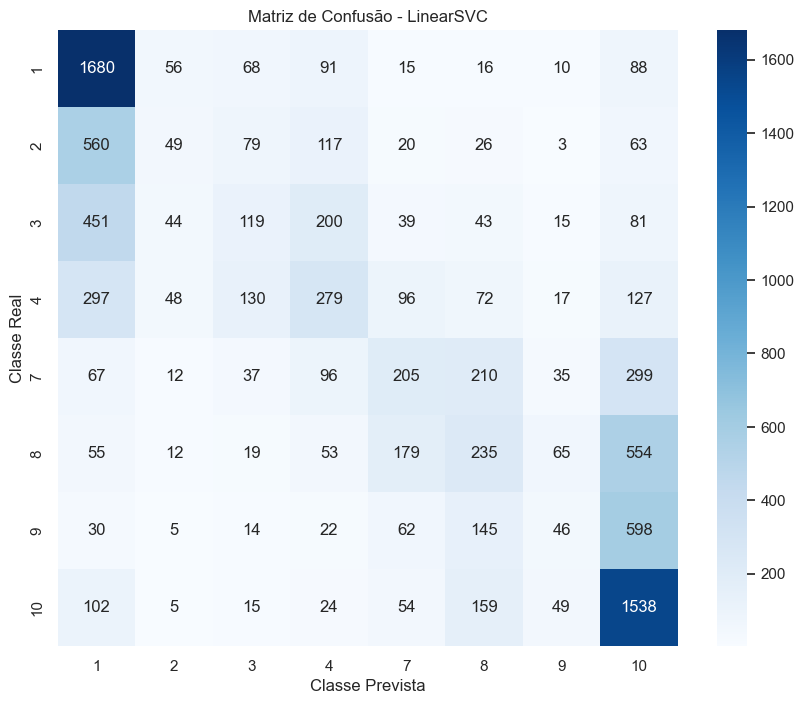


=== Classificação com Logistic Regression ===

Melhor parâmetro C encontrado: 1
Melhor accuracy na validação cruzada (Treino): 0.4162

--- Avaliação no Conjunto de Teste ---
              precision    recall  f1-score   support

           1       0.55      0.76      0.64      2024
           2       0.20      0.08      0.12       917
           3       0.25      0.16      0.20       992
           4       0.31      0.29      0.30      1066
           7       0.30      0.25      0.27       961
           8       0.27      0.23      0.25      1172
           9       0.20      0.08      0.12       922
          10       0.48      0.73      0.58      1946

    accuracy                           0.41     10000
   macro avg       0.32      0.32      0.31     10000
weighted avg       0.36      0.41      0.37     10000



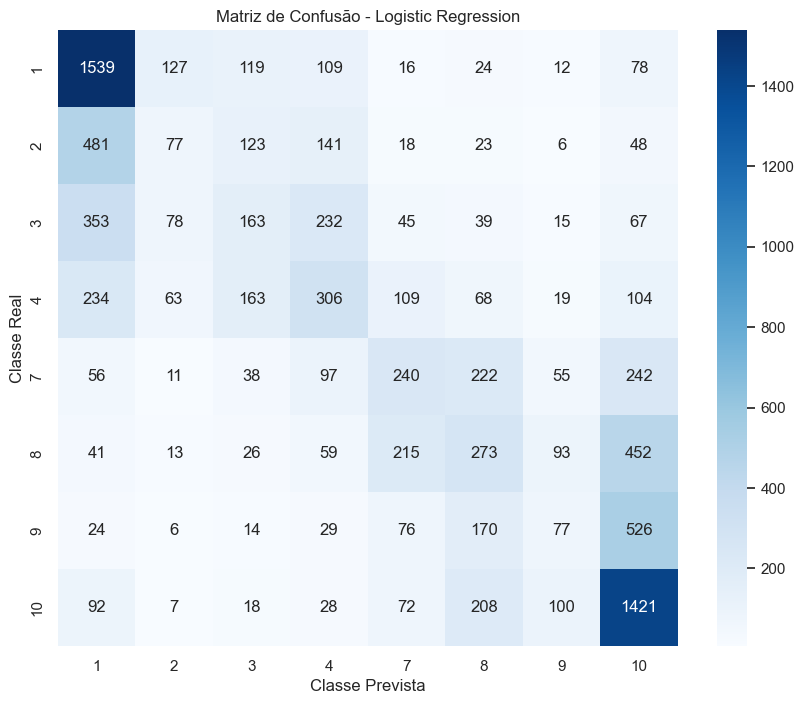

In [42]:
# =========================================================
# Classificação — LinearSVC e Logistic Regression
# =========================================================

param_grid = {'C': [0.01, 0.1, 1, 10]}

def train_and_evaluate(model, model_name):
    print(f"\n=== Classificação com {model_name} ===")

    grid = GridSearchCV(
        model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0  # Output limpo
    )

    # Treino
    grid.fit(Xtrain_tfidf, ytrain)

    # Resultados da validação cruzada
    print(f"\nMelhor parâmetro C encontrado: {grid.best_params_['C']}")
    print(f"Melhor accuracy na validação cruzada (Treino): {grid.best_score_:.4f}")

    # Avaliação no conjunto de teste
    best_model = grid.best_estimator_
    y_pred = best_model.predict(Xtest_tfidf)

    print("\n--- Avaliação no Conjunto de Teste ---")
    print(classification_report(ytest, y_pred))

    # Matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix(ytest, y_pred),
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=np.unique(ytest),
        yticklabels=np.unique(ytest)
    )
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()

    return best_model


# Linear SVM
svc = LinearSVC(dual='auto', random_state=42, max_iter=2000)
best_svc = train_and_evaluate(svc, "LinearSVC")

# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)
best_lr = train_and_evaluate(lr, "Logistic Regression")


Após a aplicação dos modelos de classificação, foi também explorada uma abordagem
de **regressão**, utilizando o modelo **`Ridge Regression`**, mantendo exatamente
o mesmo vocabulário construído com **TF-IDF**. Desta forma, garante-se que as
diferenças observadas nos resultados se devem apenas ao tipo de modelo utilizado
e não à representação dos dados.

O modelo Ridge corresponde a uma regressão linear com regularização L2, sendo
adequado para conjuntos de dados com elevada dimensionalidade, como é o caso dos
textos vetorizados com TF-IDF. A regularização permite reduzir o risco de
sobreajuste, penalizando coeficientes demasiado elevados.

Para selecionar o melhor valor do parâmetro de regularização `alpha`, foi
utilizado o `GridSearchCV` com validação cruzada (`cv=3`). Este parâmetro controla
a intensidade da regularização:
- valores mais baixos de `alpha` permitem maior flexibilidade do modelo;
- valores mais elevados conduzem a modelos mais simples, com coeficientes mais
  reduzidos.

Foram testados os valores `alpha = {1, 10, 100, 1000}`, de modo a analisar
diferentes níveis de regularização. A métrica utilizada na validação cruzada foi
o **R²**, que avalia a qualidade do ajuste do modelo de regressão.

Após o treino, o melhor modelo foi utilizado para prever valores contínuos no
conjunto de teste. O desempenho da regressão foi avaliado através do
**Erro Quadrático Médio (MSE)**, que mede a diferença média entre os valores reais
e os valores previstos.

Como o objetivo do trabalho passa também pela comparação com os modelos de
classificação, as previsões contínuas obtidas pela regressão foram convertidas em
classes discretas. Para isso:
- os valores previstos foram arredondados para o inteiro mais próximo;
- as previsões foram limitadas ao intervalo válido `[1, 10]`;
- como a base de dados não contém as classes 5 e 6, estas foram mapeadas para as
  classes mais próximas existentes (`5 → 4` e `6 → 7`).

Após esta conversão, foi possível avaliar o modelo de regressão como se de um
classificador se tratasse, recorrendo ao `classification_report` e à matriz de
confusão. Esta abordagem permite comparar diretamente os resultados da
**classificação direta** com os obtidos através da **regressão seguida de
quantização**, conforme solicitado no enunciado.


=== Regressão com Ridge ===

Melhor valor de alpha: 1.0
Melhor R² médio na validação cruzada: 0.5946
MSE no conjunto de teste: 4.6580

--- Relatório de Classificação (Via Regressão) ---
              precision    recall  f1-score   support

           1       0.64      0.26      0.37      2024
           2       0.22      0.18      0.20       917
           3       0.19      0.20      0.19       992
           4       0.21      0.43      0.28      1066
           7       0.20      0.51      0.28       961
           8       0.21      0.21      0.21      1172
           9       0.22      0.21      0.21       922
          10       0.56      0.19      0.28      1946

    accuracy                           0.26     10000
   macro avg       0.31      0.27      0.25     10000
weighted avg       0.36      0.26      0.27     10000



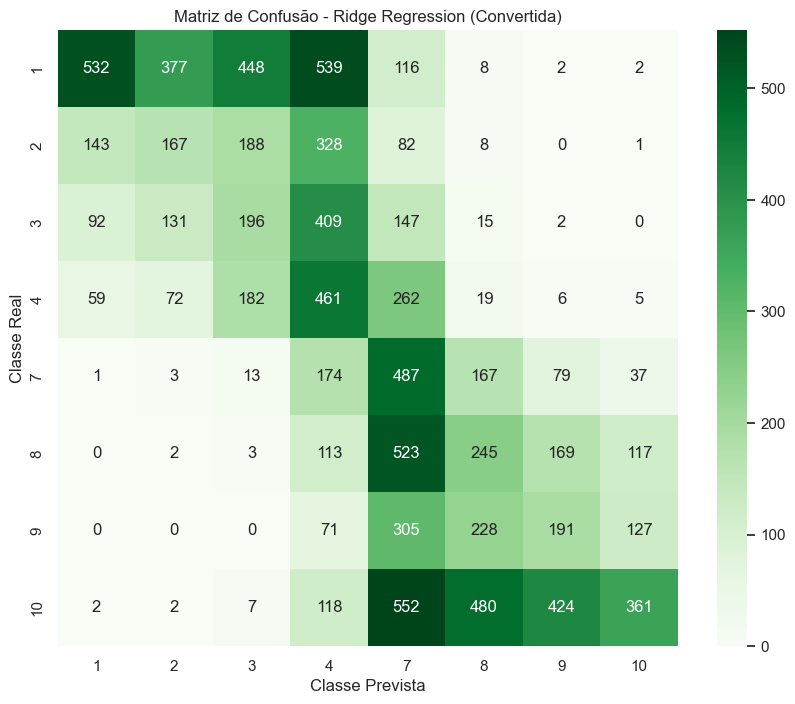

In [43]:
# =========================================================
# Regressão com Ridge (usando o mesmo vocabulário TF-IDF)
# =========================================================

print("=== Regressão com Ridge ===")

# Grelha de parâmetros
# alpha controla a força da regularização:
# valores mais altos -> coeficientes mais pequenos (modelo mais simples)
param_grid_ridge = {
    'alpha': [1.0, 10.0, 100.0, 1000.0]
}

# Configuração do modelo Ridge
ridge = Ridge(random_state=42)

# GridSearch com validação cruzada (cv=3)
# A métrica R² é usada para avaliar a qualidade do ajuste em regressão
grid_search_ridge = GridSearchCV(
    ridge,
    param_grid_ridge,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

# Treino do modelo
grid_search_ridge.fit(Xtrain_tfidf, ytrain)

# Melhor modelo encontrado e métricas de validação
best_ridge = grid_search_ridge.best_estimator_
print(f"\nMelhor valor de alpha: {grid_search_ridge.best_params_['alpha']}")
print(f"Melhor R² médio na validação cruzada: {grid_search_ridge.best_score_:.4f}")

# Previsões contínuas no conjunto de teste
y_pred_continuous = best_ridge.predict(Xtest_tfidf)

# Métrica de regressão: Erro Quadrático Médio (MSE)
mse = mean_squared_error(ytest, y_pred_continuous)
print(f"MSE no conjunto de teste: {mse:.4f}")

# =========================================================
# Conversão das previsões contínuas para classes discretas
# =========================================================

# Arredondar para o inteiro mais próximo
y_pred_converted = np.round(y_pred_continuous).astype(int)

# Garantir que as previsões ficam dentro do intervalo válido [1, 10]
y_pred_converted = np.clip(y_pred_converted, 1, 10)

# A base de dados não contém as classes 5 e 6:
# - 5 é mapeado para 4 (classe negativa)
# - 6 é mapeado para 7 (classe positiva)
y_pred_converted = np.where(y_pred_converted == 5, 4, y_pred_converted)
y_pred_converted = np.where(y_pred_converted == 6, 7, y_pred_converted)

# Avaliação da regressão após conversão para classes
print("\n--- Relatório de Classificação (Via Regressão) ---")
print(classification_report(ytest, y_pred_converted))

# Matriz de Confusão
plt.figure(figsize=(10, 8))
conf_mat_reg = confusion_matrix(ytest, y_pred_converted)

sns.heatmap(
    conf_mat_reg,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=np.unique(ytest),
    yticklabels=np.unique(ytest)
)

plt.title('Matriz de Confusão - Ridge Regression (Convertida)')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

#### Comparação de Resultados: Classificação vs. Regressão

Após a aplicação dos modelos de **classificação** (LinearSVC e Logistic Regression)
e do modelo de **regressão** (Ridge), é possível comparar o comportamento das duas
abordagens utilizando exatamente a mesma representação dos dados (TF-IDF).

##### Desempenho global

Em termos de desempenho global, os modelos de **classificação** apresentaram
resultados superiores aos obtidos através da regressão convertida em classes.

- O **LinearSVC** atingiu uma accuracy de aproximadamente **42%** no conjunto de
  teste.
- A **Logistic Regression** obteve uma accuracy semelhante, cerca de **41%**.
- A abordagem de **regressão com Ridge**, após conversão das previsões contínuas
  para classes discretas, apresentou uma accuracy significativamente mais baixa,
  cerca de **26%**.

Estes valores indicam que tratar diretamente as pontuações como **classes
discretas** é mais eficaz neste conjunto de dados do que tentar modelar uma
escala numérica contínua através de regressão.

##### Análise do comportamento por classes

A análise dos *classification reports* e das matrizes de confusão permite
identificar diferenças claras no comportamento dos modelos:

- **Classificação (LinearSVC e Logistic Regression):**
  - Os modelos apresentam melhor desempenho nas classes extremas, em particular
    nas classes **1** e **10**, que correspondem a críticas muito negativas e muito
    positivas.
  - As classes intermédias (2, 3, 4, 7, 8 e 9) são mais difíceis de distinguir,
    sendo frequentemente confundidas entre si.
  - Este comportamento sugere que os modelos conseguem captar bem sentimentos
    fortes, mas têm maior dificuldade em separar opiniões mais moderadas.

- **Regressão (Ridge):**
  - Observa-se um fenómeno de **regressão à média**, visível na matriz de confusão.
  - O modelo tende a concentrar previsões nas classes centrais (principalmente
    **4** e **7**), evitando valores extremos.
  - Este comportamento resulta do objetivo do modelo de regressão, que procura
    minimizar o **Erro Quadrático Médio (MSE ≈ 4.66)**, penalizando previsões muito
    afastadas do valor real.
  - Como consequência, o modelo perde capacidade para identificar críticas
    claramente muito boas ou muito más.

##### Conclusão

Os resultados obtidos mostram que, para este problema, a **classificação direta**
é mais adequada do que a regressão seguida de quantização.  

Se o objetivo for identificar claramente críticas **muito positivas** ou
**muito negativas**, os modelos de classificação (especialmente o LinearSVC)
apresentam melhor desempenho.  

A abordagem de regressão pode ser útil para estimar uma **pontuação média**, mas
não é eficaz quando o objetivo passa por distinguir classes discretas com maior
precisão, especialmente nos extremos da escala de avaliação.


### 3.3 Metodologias de teste e métricas de desempenho <a id="desempenho"></a>

De forma a obter uma estimativa fidedigna do desempenho dos modelos treinados,
foram adotadas metodologias de teste adequadas a cada tipo de tarefa, bem como
métricas apropriadas para a sua avaliação.

Numa primeira fase, o conjunto de dados foi dividido em subconjuntos de treino e
teste, utilizando uma proporção de **80% para treino** e **20% para teste**.
A divisão foi realizada de forma aleatória e com **estratificação**, garantindo
que a distribuição das classes se mantém semelhante em ambos os subconjuntos.
Esta abordagem permite avaliar o desempenho dos modelos em dados nunca vistos
durante o treino.

Para a seleção de hiperparâmetros e para uma avaliação mais robusta do
desempenho durante o treino, foi utilizada **validação cruzada** com
`cv = 3`, recorrendo ao método `GridSearchCV`. Esta técnica reduz a dependência
de uma única divisão dos dados e permite uma escolha mais fiável dos parâmetros
ótimos dos modelos.

No caso da **classificação**, as métricas utilizadas foram:
- **Accuracy**, que mede a proporção total de previsões corretas;
- **Precision**, **Recall** e **F1-score**, que permitem analisar o desempenho
  por classe, sendo especialmente relevantes num problema multi-classe;
- **Matriz de confusão**, utilizada para identificar padrões de erro e classes
  frequentemente confundidas entre si.

Para a tarefa de **regressão**, foram utilizadas métricas adequadas a modelos
contínuos:
- **R²**, utilizado durante a validação cruzada, que avalia a qualidade do ajuste
  do modelo;
- **Erro Quadrático Médio (MSE)**, calculado no conjunto de teste, que mede a
  diferença média entre os valores reais e os valores previstos.

De modo a permitir uma comparação direta entre classificação e regressão, as
previsões contínuas obtidas pelo modelo de regressão foram posteriormente
convertidas em classes discretas, possibilitando o cálculo das mesmas métricas
utilizadas na classificação.

Estas metodologias de teste e métricas de desempenho permitem uma avaliação
consistente e justa dos modelos, garantindo que os resultados apresentados
refletem de forma realista a capacidade de generalização dos modelos treinados.

### 3.4 Clustering <a id="clustering"></a>

Nesta última tarefa do trabalho foi realizada uma análise de **clustering**, com o
objetivo de agrupar as críticas de cinema de forma **não supervisionada**, ou seja,
sem utilizar as pontuações associadas às críticas.

Para esta tarefa foi utilizado o algoritmo **K-Means**, por ser um método simples,
eficiente e bastante utilizado em problemas de agrupamento com dados de elevada
dimensionalidade, como textos representados através de **TF-IDF**.

#### Variação do número de clusters

De acordo com o enunciado, foram testados diferentes valores para o número de
clusters, nomeadamente **k = 3, 5 e 8**, de forma a analisar o impacto da variação de
`k` na organização dos dados.

Em todos os casos, o algoritmo foi treinado apenas com o conjunto de treino
(`Xtrain_tfidf`), mantendo consistência com as tarefas anteriores do trabalho.

#### Análise dos termos representativos dos clusters

Para interpretar semanticamente cada cluster, foram analisadas as palavras com
maior peso nos centróides de cada grupo. Estas palavras permitem compreender que
tipo de críticas tende a ser agrupado em cada cluster.

Observou-se que, para valores mais baixos de `k` (por exemplo, `k = 3`), os clusters
são definidos sobretudo por vocabulário geral associado a filmes, não sendo ainda
muito específicos. À medida que o número de clusters aumenta, os grupos tornam-se
mais especializados e semanticamente mais distintos.

#### Visualização dos clusters

Para facilitar a interpretação dos resultados, foi utilizada a técnica de
**PCA (Principal Component Analysis)** para reduzir a dimensionalidade dos dados
para duas componentes principais. Esta redução foi aplicada apenas para efeitos
de visualização e não influencia o processo de clustering.

Os gráficos obtidos permitem observar como os clusters se distribuem no espaço
reduzido e como a separação entre grupos se torna mais evidente com o aumento do
número de clusters.



=== Clustering ===

--- A treinar K-Means com k=3 ---
Principais termos por cluster (k=3):
Cluster 0: movi, like, watch, bad, just, good, realli
Cluster 1: film, like, veri, movi, just, charact, good
Cluster 2: movi, film, like, time, charact, just, stori


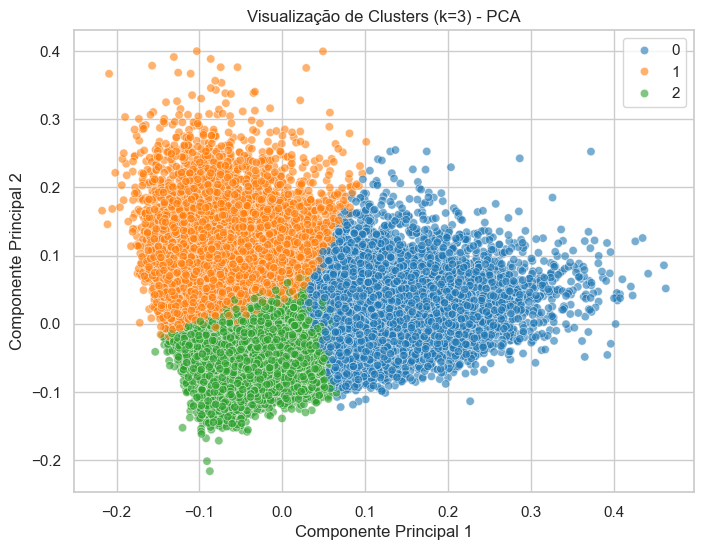


--- A treinar K-Means com k=5 ---
Principais termos por cluster (k=5):
Cluster 0: film, veri, like, charact, movi, good, make
Cluster 1: movi, bad, just, like, film, realli, good
Cluster 2: film, movi, stori, time, like, love, play
Cluster 3: movi, watch, like, good, just, veri, time
Cluster 4: episod, seri, season, watch, tv, like, charact


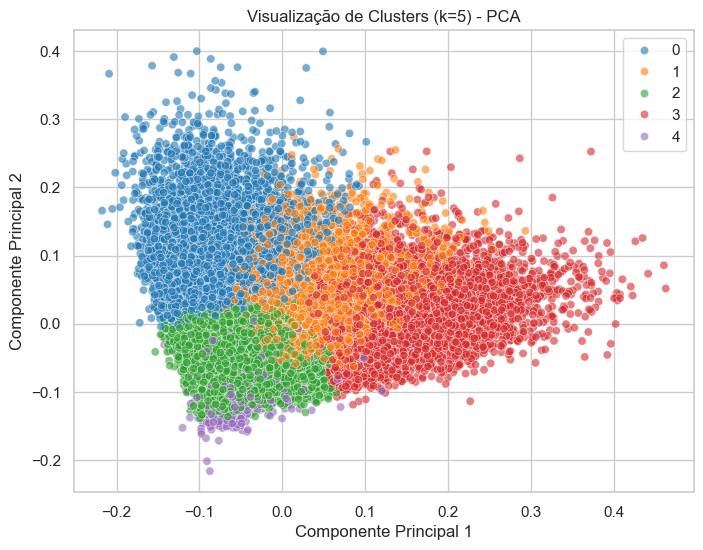


--- A treinar K-Means com k=8 ---
Principais termos por cluster (k=8):
Cluster 0: episod, seri, season, watch, tv, like, charact
Cluster 1: movi, like, just, film, realli, watch, make
Cluster 2: film, veri, like, good, charact, make, movi
Cluster 3: movi, watch, like, good, just, veri, time
Cluster 4: film, movi, stori, play, veri, time, love
Cluster 5: book, movi, read, novel, film, stori, adapt
Cluster 6: music, song, danc, film, movi, sing, love
Cluster 7: bad, movi, act, film, just, good, watch


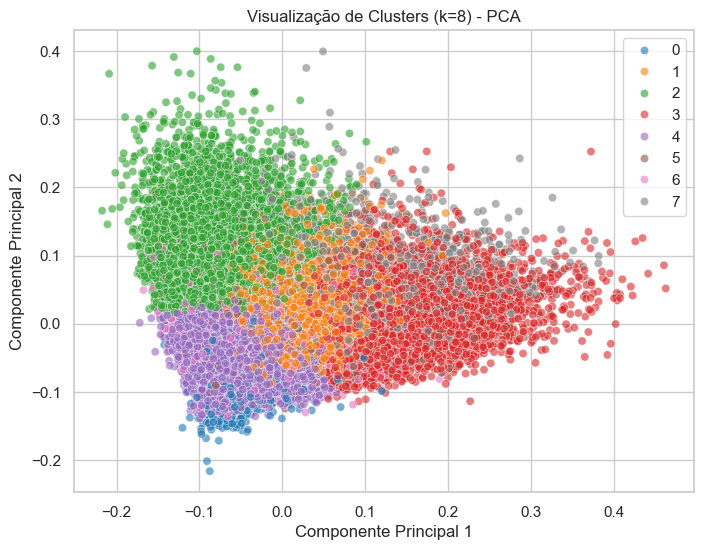

In [44]:
# =========================================================
# Clustering com K-Means
# =========================================================

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("\n=== Clustering ===")

# Diferentes valores de k a testar
k_values = [3, 5, 8]

# Redução de dimensionalidade para visualização (PCA 2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xtrain_tfidf.toarray())  # apenas para visualização

# Guardar modelos treinados
kmeans_models = {}

for k in k_values:
    print(f"\n--- A treinar K-Means com k={k} ---")
    
    # Treinar K-Means
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(Xtrain_tfidf)
    kmeans_models[k] = kmeans
    
    # Análise dos termos mais representativos de cada cluster
    print(f"Principais termos por cluster (k={k}):")
    
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    for i in range(k):
        top_terms = [terms[ind] for ind in order_centroids[i, :7]]
        print(f"Cluster {i}: {', '.join(top_terms)}")
    
    # Visualização dos clusters em 2D (PCA)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=kmeans.labels_,
        palette='tab10',
        legend='full',
        alpha=0.6
    )
    
    plt.title(f'Visualização de Clusters (k={k}) - PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()


#### Análise dos Resultados de Clustering

A aplicação do algoritmo K-Means revelou padrões semânticos latentes no *corpus* de críticas. Observou-se que o aumento do número de clusters ($k$) permitiu passar de uma separação baseada em sentimento/vocabulário geral para uma separação baseada em **tópicos específicos**.

**Interpretação dos Grupos (com $k=8$):**
A configuração com 8 clusters provou ser a mais informativa, revelando agrupamentos temáticos distintos que não dependem da pontuação do filme, mas sim do seu conteúdo:

1.  **Séries Televisivas (Cluster 0):** Definido por termos como *episod*, *seri*, *season*, *tv*. O algoritmo isolou com sucesso as críticas a séries, distinguindo-as de filmes.
2.  **Adaptações Literárias (Cluster 5):** Caracterizado por palavras como *book*, *read*, *novel*, *adapt*. Este grupo reúne críticas que comparam a obra cinematográfica com a sua fonte literária.
3.  **Musicais (Cluster 6):** Dominado por termos como *music*, *song*, *danc*, *sing*.
4.  **Sentimento Negativo (Cluster 7):** Agrupou críticas fortemente negativas (*bad*, *act*), sugerindo que o vocabulário usado para "destruir" um filme é semanticamente consistente, independentemente do género do filme.

**Conclusão do Agrupamento:**
O K-Means, em conjunto com a representação TF-IDF, demonstrou ser eficaz não apenas para separar filmes bons de maus, mas para organizar a base de dados por género (Musicais) e formato (TV vs Cinema vs Livros) de forma totalmente não supervisionada.

---

## 4. Conclusão <a id="conclusao"></a>

Neste trabalho foi desenvolvido um sistema completo para a análise de críticas de cinema do IMDb, abrangendo tarefas de **classificação**, **regressão** e **clustering**, sempre utilizando a mesma representação dos dados baseada em **TF-IDF**.

De um modo geral, os resultados mostram que a forma como o problema é modelado tem um impacto significativo no desempenho obtido.

Na tarefa de **classificação**, o modelo **LinearSVC** apresentou os melhores resultados, com uma accuracy a rondar os **41%**. Tendo em conta o número elevado de classes e a natureza subjetiva das avaliações, este valor pode ser considerado satisfatório. Observou-se que o modelo consegue identificar bem críticas muito negativas e muito positivas (classes 1 e 10), mas tem maior dificuldade em distinguir avaliações intermédias, o que é expectável neste tipo de problema. A comparação com a Regressão Logística mostrou desempenhos semelhantes, confirmando que modelos lineares simples são eficazes para esta tarefa.

Relativamente à **regressão**, o modelo **Ridge** revelou limitações claras quando aplicado a este conjunto de dados. Embora tenha conseguido obter um valor razoável de erro médio, verificou-se um efeito de *regressão à média*, com o modelo a evitar previsões extremas. Como consequência, a conversão das previsões contínuas em classes resultou numa accuracy bastante inferior à dos modelos de classificação. Assim, conclui-se que a regressão não é a abordagem mais adequada quando o objetivo é distinguir claramente avaliações muito boas ou muito más.

Na tarefa de **clustering**, o algoritmo **K-Means** mostrou-se particularmente interessante. Mesmo sem utilizar qualquer informação sobre as pontuações, foi capaz de agrupar críticas com base em tópicos específicos, como séries de televisão, musicais ou adaptações literárias. Este resultado demonstra que a representação TF-IDF consegue capturar informação semântica relevante para além do simples sentimento da crítica.

Em conclusão, este trabalho evidencia a importância do **pré-processamento dos textos** e da **representação dos dados** na aprendizagem automática aplicada a texto. Para este problema em concreto, a **classificação direta** revelou-se a abordagem mais eficaz. Como trabalho futuro, poderia ser interessante explorar representações mais avançadas, como *word embeddings* ou modelos baseados em *transformers*, de forma a captar melhor o contexto das palavras e melhorar a distinção entre classes intermédias.
